In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
class RandomFunction(nn.Module):
    def __init__(self):
        super(RandomFunction, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=100)
#         self.fc2 = nn.Linear(in_features=100, out_features=100)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
#         x = self.act(self.fc2(x))
        return x
rf = RandomFunction().cuda()

In [3]:
dataset_features = np.random.uniform(size=(1000, 2))
ds_f_torch = torch.from_numpy(dataset_features).to(torch.float32).cuda()

In [4]:
ds_obs = rf(ds_f_torch).detach()

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(100)
        self.bn2 = torch.nn.BatchNorm1d(50)
        self.fc1 = nn.Linear(in_features=100, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=4)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [6]:
decoder = Decoder().cuda()

In [7]:
opt = torch.optim.Adam(decoder.parameters(), lr=1e-3, betas=(0.8, 0.8))

In [ ]:
ds_obs_orig = ds_obs.clone()

In [ ]:
@gin.configurable
def siamese_feature_discriminator_l2_fake_is(obs, decoder, obs_delta_eps=1e-10,
                                     margin=1.0,
#                                      margin_same_not_farther=5.0,
                                     max_dist=500,
                                     **kwargs):
    def loss(y_true, y_pred):
        """L2 norm for the distance, no flat."""
        delta = y_true - y_pred
        delta = delta.pow(2)
        delta = delta.flatten(start_dim=1)
        delta = delta.sum(1)
        return delta

    # original inputs order
    batch_dim = obs.shape[0]

    # random permutation for incorrect inputs
    idxes = torch.randperm(batch_dim).to(obs.device)
    obs_shuffled = obs[idxes]

    idxes_orig = torch.arange(start=0, end=batch_dim).to(obs.device)
    target_close = ((obs - obs_shuffled).flatten(start_dim=1).pow(2).sum(1) <=\
                        obs_delta_eps).to(obs.device).detach()

    # distance_shuffle = loss(obs, obs_shuffled)
    decoded = decoder(obs)
    distance_f = loss(decoded, decoder(obs_shuffled))

    # print(torch.nn.ReLU()(margin - distance_f), torch.where)

#     torch.where(target_close,
# #                                 torch.nn.ReLU()(distance_f - margin_same_not_farther),
#                                 torch.nn.ReLU()(margin_different_not_closer - distance_f[~])
#                                ).mean(),
    
    loss_max_dist = torch.nn.ReLU()(distance_f - max_dist).mean()
    
    loss = torch.tensor(0.0, dtype=torch.float32).cuda()
#     loss += loss_max_dist.mean() / max_dist
    if ((~target_close).sum().item() > 0):
        loss = (torch.nn.ReLU()(margin - distance_f[~target_close])).mean() / margin
    
#     print(target_close.sum())
    
    return {'loss': loss.mean(),
            'metrics': {'distance_close': distance_f[target_close].mean().item(),
                        'distance_far': distance_f[~target_close].mean().item(),
                       'norm': decoded.abs().mean().item()}
            }

In [938]:
siamese_feature_discriminator_l2_fake_is(ds_obs, decoder)

{'loss': tensor(0.3023, device='cuda:0', grad_fn=<MeanBackward0>),
 'metrics': {'distance_close': nan,
  'distance_far': 1.2515596151351929,
  'norm': 0.3105993866920471}}

In [939]:
losses = []

In [940]:
for _ in tqdm(range(10000)):
#     idx_random = np.random.choice(len(ds_obs_orig), 10, replace=False)
#     ds_obs = ds_obs_orig[idx_random, :]
    
    opt.zero_grad()
    loss = siamese_feature_discriminator_l2_fake_is(ds_obs, decoder)['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())

KeyboardInterrupt: 

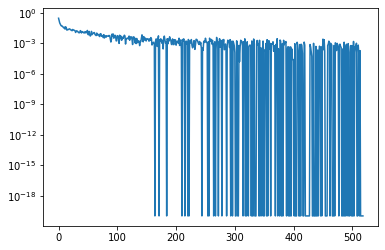

In [941]:
plt.plot(np.maximum(losses, 1e-20))
plt.yscale('log')

#### doesn't go to 0 even for this simple dataset
#### trying gan for observations...

In [1123]:
decoder = Decoder().cuda()

In [1124]:
class ObsFeatureDiscriminator(nn.Module):
    def __init__(self, decoder_cls):
        super(ObsFeatureDiscriminator, self).__init__()
        self.decoder = decoder_cls()
        self.fc1 = nn.Linear(in_features=8, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=1)
        self.act = nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(8)
        self.bn2 = torch.nn.BatchNorm1d(10)
    def forward(self, obs, features):
        my_features = self.decoder(obs)
        all_f = torch.cat([my_features, features], dim=1)
        x = all_f
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [1125]:
disc = ObsFeatureDiscriminator(Decoder).cuda()

In [1126]:
bce = torch.nn.BCEWithLogitsLoss(reduction='none')

In [1127]:
opt_gen = torch.optim.Adam(decoder.parameters(), lr=1e-3)
opt_dsc = torch.optim.Adam(list(decoder.parameters()) + list(disc.parameters()), lr=1e-3,
                          betas=(0.8, 0.9))

In [1128]:
def gen_loss():
    logits = disc(ds_obs, decoder(ds_obs)).view(-1)
    ans = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    loss = bce(logits, ans * 1.0) ** 2
    loss = loss.mean()
    return loss

In [1129]:
gen_loss()

tensor(0.5046, device='cuda:0', grad_fn=<MeanBackward0>)

In [1130]:
disc_losses = []
gen_losses = []
accs = []

In [1131]:
bce1 = torch.nn.BCEWithLogitsLoss(reduction='none')
bce1(torch.randn(10), torch.full(fill_value=1.0, size=(10,)))

tensor([0.7403, 0.9517, 0.5842, 0.6753, 0.8176, 0.2440, 1.2119, 0.2794, 1.2174,
        0.2679])

In [1132]:

def corr(X, eps=1e-08):
    D = X.shape[-1]
    std = torch.std(X, dim=-1).unsqueeze(-1)
    mean = torch.mean(X, dim=-1).unsqueeze(-1)
    X = (X - mean) / (std + eps)
    return 1/(D-1) * X @ X.transpose(-1, -2)


In [1133]:
def disc_loss(n_perms=3):
    idxes = torch.arange(0, len(ds_obs)).cuda()
    idxes_neq = []
    perms = []
    for i in range(n_perms):
        perms.append(torch.randperm(len(ds_obs)).cuda())
        neq = perms[i] != idxes
        idxes_neq.append(neq)
    
#     print(idxes)
#     all_idx_inp = torch.cat([idxes, idxes, idxes], dim=0)
#     all_idx = torch.cat([perm2, perm3, perm1], dim=0)
#     neq = all_idx_inp != all_idx
#     all_idx = all_idx[neq]
#     all_idx_inp = all_idx_inp[neq]
#     ans_true = all_idx_inp == all_idx
#     ans_true_true = idxes == idxes

    feat = decoder(ds_obs)
    
    positive_logits = disc(ds_obs, feat).view(-1)
    pos_probas = torch.nn.Sigmoid()(positive_logits)
    negative_logits = [disc(ds_obs, decoder(ds_obs[perm, :]))
                      for perm in perms]
    
    
    neg_logits_stacked = torch.stack(negative_logits, dim=0).view(n_perms, len(ds_obs))
    neg_probas_stacked = torch.exp(neg_logits_stacked)
    neq_stacked = torch.stack(idxes_neq, dim=0)
#     print(neg_logits_stacked.shape, neq_stacked.shape, (1. * neq_stacked).mean())
    n_neg = (1. * neq_stacked).sum(0)
    
    pr_st_or_0 = torch.where(neq_stacked, neg_probas_stacked,
                             torch.zeros_like(neg_probas_stacked)).sum(0)# / n_neg
    
    
    contrastive = pos_probas / (pos_probas + pr_st_or_0)
    
    contrastive = -torch.log(contrastive)
    
#     print(corr(feat.t()).shape)
    
    contrastive += (corr(feat.t()) - torch.eye(feat.shape[1]).cuda()).flatten().pow(2).mean()
    
#     contrastive += -torch.log(pos_probas)
    
    def acc_logits(ans_bool, logits):
        return (1. * ((logits >= 0) == ans_bool)).mean()
    
#     print(contrastive)
    
#     acc = []
#     acc.append(acc_logits(idxes == idxes, positive_logits))
#     for i, ans in enumerate(idxes_neq):
#         acc.append(acc_logits(~ans, negative_logits[i]))
#     acc = sum(acc) / len(acc)
    acc = 0

    return contrastive.mean(), acc
    

#     positive
    
#     logits_true = disc(ds_obs[all_idx, :],  decoder(ds_obs[all_idx_inp, :]))
#     logits_true_true = disc(ds_obs,  decoder(ds_obs))
    
#     probas = torch.nn.Sigmoid()(logits_true).view(-1)
#     probas_true = torch.nn.Sigmoid()(logits_true_true).view(-1)
# #     disc_loss = bce(logits.view(-1), 1. * ans_true)# ** 2
# #     disc_loss = disc_loss.mean()
#     def margin(probas):
#         return 2 * (probas - 0.5)
    
#     marg = 1.0 - logits_true.view(-1) * margin(ans_true * 1.0)
#     marg_true = 1.0 - logits_true_true.view(-1) * margin(ans_true_true * 1.0)
# #     print(logits, logits.view(-1) * margin(ans_true * 1.0))
# #     print(marg.min())
    
#     disc_loss_true = torch.nn.ReLU()(marg).mean(0)
#     disc_loss_true_true = torch.nn.ReLU()(marg_true).mean(0)
    
#     disc_loss = (disc_loss_true_true + disc_loss_true) / 2
# #     disc_loss = torch.abs(torch.nn.Sigmoid()(logits).view(-1) - 1. * ans_true).mean()
# #     acc = (1. * ((torch.nn.Sigmoid()(logits) > 0.5) == ans_true)).mean()
# #     return disc_loss, acc
# #     disc_loss = torch.pow(probas - (1. * ans_true), 2).mean()
#     acc_true = (1. * ((logits_true >= 0) == ans_true)).abs().mean()
#     acc_true_true = (1. * ((logits_true_true >= 0) == ans_true_true)).abs().mean()
#     acc = (acc_true + acc_true_true) / 2
#     return disc_loss, acc

In [1134]:
disc_loss()

(tensor(2.2653, device='cuda:0', grad_fn=<MeanBackward0>), 0)

In [1135]:
corr(torch.randn(1000, 100))

tensor([[ 1.0000,  0.0931,  0.0031,  ...,  0.0975, -0.1402, -0.0918],
        [ 0.0931,  1.0000,  0.0550,  ...,  0.1296, -0.0711, -0.1014],
        [ 0.0031,  0.0550,  1.0000,  ..., -0.0205, -0.0738, -0.0276],
        ...,
        [ 0.0975,  0.1296, -0.0205,  ...,  1.0000, -0.1231, -0.0315],
        [-0.1402, -0.0711, -0.0738,  ..., -0.1231,  1.0000,  0.1337],
        [-0.0918, -0.1014, -0.0276,  ..., -0.0315,  0.1337,  1.0000]])

In [1145]:
for i in tqdm(range(10000)):
    
#     idx_random = np.random.choice(len(ds_obs_orig), 10, replace=False)
#     ds_obs = ds_obs_orig[idx_random, :]
    ds_obs = ds_obs_orig
    
    opt_dsc.zero_grad()
    loss_dsc,acc = disc_loss()
    loss_dsc.backward()
    opt_dsc.step()
    
#     opt_gen.zero_grad()
#     loss_gen = gen_loss()
#     loss_gen.backward()
#     opt_gen.step()
    
    disc_losses.append(loss_dsc.item())
#     gen_losses.append(loss_gen.item())
    accs.append(acc)

KeyboardInterrupt: 

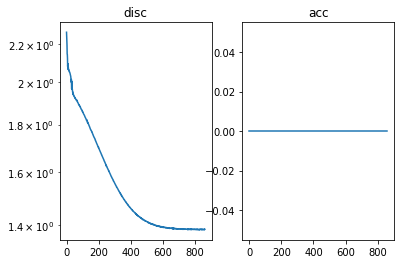

In [1146]:
plt.subplot(1, 2, 1)
plt.title('disc')
plt.plot(disc_losses)
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.title('acc')
plt.plot(accs)

In [1147]:
ds_obs.shape

torch.Size([1000, 100])

In [1148]:
acc

0

In [1149]:
df = pd.DataFrame(decoder(ds_obs).detach().cpu().numpy())

In [1150]:
df.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.118412,-0.047200,-0.120774,-0.022286
std,1.546153,0.502767,0.845267,0.485985
min,-2.467574,-1.262424,-1.459227,-0.949707
25%,-1.715803,-0.469142,-0.945516,-0.431251
50%,-0.002062,0.014472,-0.088957,-0.021215
75%,1.331192,0.353089,0.642932,0.348334
max,2.201474,0.969137,1.254375,1.152853


<AxesSubplot:>

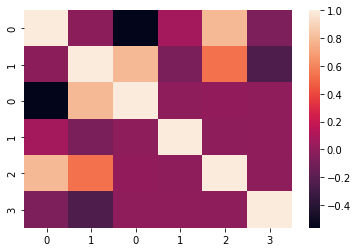

In [1151]:
sns.heatmap(pd.concat([pd.DataFrame(dataset_features), df], axis=1).corr())

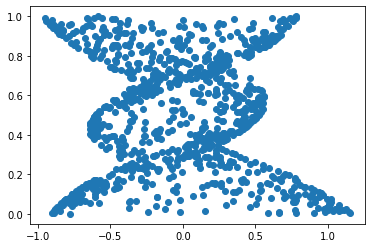

In [1152]:
plt.scatter(df[3], dataset_features[:, 0])# - dataset_features[:, 1])

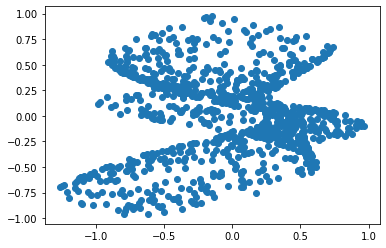

In [1153]:
plt.scatter(df[1], dataset_features[:, 0] - dataset_features[:, 1])

# GAN and a reconstructor

In [196]:
bce = torch.nn.BCEWithLogitsLoss(reduction='none')

In [197]:
decoder = Decoder().cuda()

In [198]:
class Reconstructor(nn.Module):
    def __init__(self):
        super(Reconstructor, self).__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=100)
        self.act = nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(4)
        self.bn2 = torch.nn.BatchNorm1d(50)
    def forward(self, x):
        x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x
rec = Reconstructor().cuda()

In [211]:
class ReconstructedDiscriminator(nn.Module):
    def __init__(self, decoder_cls):
        super(ReconstructedDiscriminator, self).__init__()
        self.decoder1 = decoder_cls()
#         self.decoder2 = decoder_cls()
        self.fc1 = nn.Linear(in_features=100, out_features=1)
#         self.fc2 = nn.Linear(in_features=50, out_features=1)
        self.act = nn.Tanh()
        self.bn = torch.nn.BatchNorm1d(100)
    def forward(self, obs_1, obs_2):
        z = (obs_1 - obs_2).pow(2)
#         z = self.bn(z)
#         f1 = self.decoder1(z)
#         f2 = self.decoder1(obs_2)
#         all_f = f1 - f2
        all_f = z#f1
#         f2 = self.decoder1(obs_2)
#         all_f = torch.cat([f1, f2], dim=1)
#         all_f = f1
        x = all_f
#         x = self.act(self.fc1(x))
        x = self.fc1(x)
        return x

In [212]:
disc = ReconstructedDiscriminator(Decoder).cuda()

In [201]:
def disc_loss():
    logits_true = disc(ds_obs, ds_obs)
    probas_true = torch.nn.Sigmoid()(logits_true).view(-1)
    ans_true = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    disc_loss_true = bce(logits_true.view(-1), 1. * ans_true).mean()
    acc_true = (1. * ((probas_true >= 0.5) == ans_true)).abs().mean()
    
    logits_false = disc(ds_obs, rec(decoder(ds_obs)))
    probas_false = torch.nn.Sigmoid()(logits_false).view(-1)
    ans_false = torch.full(fill_value=False, size=(ds_obs.shape[0],)).cuda()
    disc_loss_false = bce(logits_false.view(-1), 1. * ans_false).mean()
    acc_false = (1. * ((probas_false >= 0.5) == ans_false)).abs().mean()
    
    return (disc_loss_true + disc_loss_false) / 2, (acc_true + acc_false) / 2

def gen_loss():
    logits_false = disc(ds_obs, rec(decoder(ds_obs)))
    probas_false = torch.nn.Sigmoid()(logits_false).view(-1)
    ans_false = torch.full(fill_value=True, size=(ds_obs.shape[0],)).cuda()
    disc_loss_false = bce(logits_false.view(-1), 1. * ans_false).mean()
    acc_false = (1. * ((probas_false >= 0.5) == ans_false)).abs().mean()
    
    return disc_loss_false, acc_false

def gen_loss_l2():
    ds_rec_obs = rec(decoder(ds_obs))
    delta = ds_obs - ds_rec_obs
    delta = delta.pow(2).sum(1).mean()
    return delta

In [202]:
class VarianceLossLRDecay():
    """If the variance is lower than the improvement by a factor, decrease the lr.
    
    When reached minimal learning rate, reset to default one and reset the optimizer."""
    def __init__(self, optimizer, factor_lr_decrease=0.5,
                 grace_epochs=1000,
                 var_factor=5,
                 min_lr=1e-6,
                 default_lr=1e-3,
                 rolling_epochs=100):
        self.optimizer = optimizer
        self.factor_lr_decrease = factor_lr_decrease
        self.grace_epochs = grace_epochs
        self.rolling_epochs = rolling_epochs
        self.var_factor = var_factor
        self.min_lr = min_lr
        self.default_lr = default_lr
        self.reset()
        
    def set_lr(self, lr):
        self.lr = lr
        for g in self.optimizer.param_groups:
            g['lr'] = self.lr
        
    def reset(self):
        self.epochs = 0
        self.loss_history = []
        self.set_lr(self.default_lr)
        
    def step(self, loss_value):
        if hasattr(loss_value, 'item'):
            loss_value = loss_value.item()
        self.loss_history.append(loss_value)
        self.epochs += 1
        
        if len(self.loss_history) >= self.grace_epochs + self.rolling_epochs and (self.epochs % self.grace_epochs) == 0:
            smoothed_loss = pd.Series(self.loss_history).rolling(self.rolling_epochs).median()
#             print("smoothed len", len(smoothed_loss))
            smoothed_loss = list(smoothed_loss)
            smoothed_loss_then = smoothed_loss[-self.grace_epochs]
            smoothed_loss_now = smoothed_loss[-1]
            
            # example: then=1, now=-1 -> improvement = 2/1=2
            absolute_improvement = (smoothed_loss_then - smoothed_loss_now)# / smoothed_loss_then
            loss_std = np.abs(np.std(self.loss_history[-self.grace_epochs:]) - np.std(smoothed_loss[-self.grace_epochs:]))
            
            print(f"Epoch {self.epochs} abs improvement {absolute_improvement} {loss_std}")
            
#             if relative_improvement < self.factor_loss_relative:
            if absolute_improvement < loss_std * self.var_factor:
                self.set_lr(self.lr * self.factor_lr_decrease)
                print(f'Decreasing lr...')
                
        if self.lr < self.min_lr:
            self.reset()

In [203]:
disc_loss(), gen_loss(), gen_loss_l2()

((tensor(0.7091, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.3315, device='cuda:0')),
 (tensor(0.7679, device='cuda:0', grad_fn=<MeanBackward0>),
  tensor(0.3370, device='cuda:0')),
 tensor(56.5049, device='cuda:0', grad_fn=<MeanBackward0>))

In [213]:
opt_disc = torch.optim.Adam(disc.parameters(), lr=1e-3)
opt_l2 = torch.optim.Adam(list(decoder.parameters()) + list(rec.parameters()), lr=1e-3)
opt_rec = torch.optim.Adam(list(decoder.parameters()) + list(rec.parameters()), lr=1e-3)

In [214]:
sch_disc = VarianceLossLRDecay(opt_disc)
sch_l2 = VarianceLossLRDecay(opt_l2)
sch_rec = VarianceLossLRDecay(opt_rec)

In [206]:
acc_gens = []
acc_discs = []
loss_gens = []
loss_discs = []
loss_l2s = []

In [227]:
for i in tqdm(range(10000)):
    opt_l2.zero_grad()
    gl2 = gen_loss_l2()
    loss =  gl2
    loss.backward()
    sch_l2.step(loss.item())
    opt_l2.step()
    
    opt_rec.zero_grad()
    gl, acc_gen = gen_loss()
    loss =  gl
    loss.backward()
    sch_rec.step(loss.item())
    opt_rec.step()
    
    opt_disc.zero_grad()
    dl, acc_dsc = disc_loss()
    loss = dl
    loss.backward()
    sch_disc.step(loss.item())
    opt_disc.step()
    
    acc_gens.append(acc_gen.item())
    acc_discs.append(acc_dsc.item())
    loss_gens.append(gl.item())
    loss_discs.append(dl.item())
    loss_l2s.append(gl2.item())

Epoch 6000 abs improvement -0.016544847283512354 0.0007020072811299554
Decreasing lr...
Epoch 4000 abs improvement 0.0028651654720306396 0.00017872561369121007
Epoch 6000 abs improvement 0.003237992525100708 0.0001296460976364319
Epoch 7000 abs improvement 0.024433221173239872 0.0033029822374910558
Epoch 5000 abs improvement -0.003494769334793091 0.00047532209042608467
Decreasing lr...
Epoch 7000 abs improvement -0.0050498247146606445 0.0007502306554823415
Decreasing lr...
Epoch 8000 abs improvement -0.009668311366112903 0.000873248533444863
Decreasing lr...
Epoch 6000 abs improvement 0.0020697712898254395 0.00017279208307790844
Epoch 8000 abs improvement 0.0019134879112243652 0.00018391335074068027
Epoch 9000 abs improvement 0.00961311673745513 0.0011961563820380413
Epoch 7000 abs improvement -0.0019972920417785645 0.00021142943068749238
Decreasing lr...
Epoch 9000 abs improvement -0.001904994249343872 0.0002474153616021463
Decreasing lr...
Epoch 10000 abs improvement -0.0059396217111

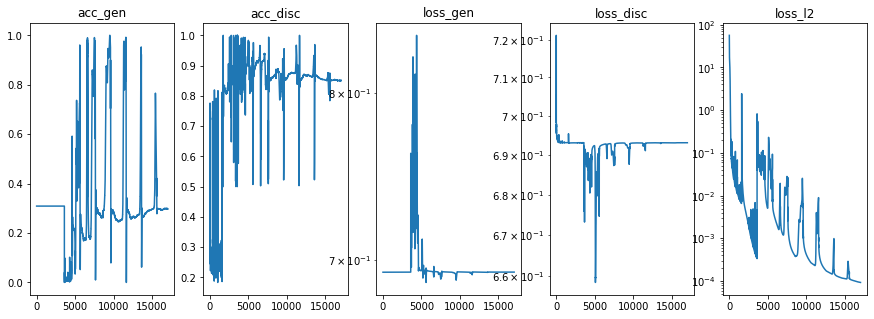

In [228]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.plot(acc_gens)
plt.title('acc_gen')

plt.subplot(1, 5, 2)
plt.plot(acc_discs)
plt.title('acc_disc')

plt.subplot(1, 5, 3)
plt.plot(loss_gens)
plt.title('loss_gen')
plt.yscale('log')

plt.subplot(1, 5, 4)
plt.plot(loss_discs)
plt.title('loss_disc')
plt.yscale('log')

plt.subplot(1, 5, 5)
plt.plot(loss_l2s)
plt.title('loss_l2')
plt.yscale('log')